# Residual Plot Analysis — ExoALMA Data

This notebook analyzes residual plots from the ExoALMA program (Curone et al. 2025, Paper IV) to extract flux limits potentially associated with planet-forming signatures within the annuli of protoplanetary disks. The aim is not to spatially characterize these features — which are likely unresolved — but to constrain potential circumplanetary disk (CPD) properties using up-to-date CPD emission models, and to compare model performance in terms of predictive power.

**Reference**:  
Curone, P., Facchini, S., Andrews, S. M., et al. (2025). *exoALMA. IV. Substructures, Asymmetries, and the Faint Outer Disk in Continuum Emission*. *The Astrophysical Journal Letters*, **984**(1), L9. https://doi.org/10.3847/2041-8213/adc438


In [1]:
# import necessary libraries

import os  
import numpy as np  
import re  # Python’s regular expressions module to extract numbers from filenames
from astropy.io import fits
import pandas as pd
from gofish import imagecube
import matplotlib.pyplot as plt



c:\Users\LHEM\AppData\Local\Programs\Python\Python312\Lib\site-packages\gofish\gofish.py:3639: SyntaxWarning: invalid escape sequence '\-'
  """


# Add a paragraph to describe the class

In [ ]:
# Load the residual fits file for each disk and store them in class then in object  

# --------------------------------------------------------
# Define a class (stores functions) for handling each disk
# --------------------------------------------------------
class DiskResiduals:
    def __init__(self, name, path, geom_file):
        """
        Initializes a DiskResiduals object for one disk.
        - name: Disk name (e.g., 'AA_Tau')
        - path: Path to its residuals folder
        - geom_file: Full path to geometry .txt file
        - distance_pc: Distance to the disk in parsecs, used for unit conversion
        """
        self.name = name
        self.path = path
        self.inc, self.PA, self.center = self._load_geometry(geom_file)
        self.residuals = {}  # Dict to store {Briggs index value: FITS data}
        self.clean_images = {}   # Dict to store {Briggs index value: FITS data} for CLEAN images
        self.clean_profile = None  # Dict to store {Briggs index value: profile data}, currently None

    def _load_geometry(self, filepath):
        """
        Reads a galario geometry .txt file and returns (inc, PA, (dRA, dDec)).
        """
        with open(filepath, "r") as f:
            lines = [line for line in f.readlines() if not line.startswith("#")]  # Skip comment lines
        best_fit = [float(x) for x in lines[0].split()]  # Extract numbers from the first row of value
        inc, PA, dRA, dDec = best_fit  # Unpack the values ,excluding the rows below corresponding to errors
        return inc, PA, (dRA, dDec)   
    
    def load_disksize(self, radii_file):
        """Load R90 (disk size) and its errors from file, store as self.disksize (dict, arcsec)."""
        arr = np.loadtxt(radii_file, comments="#")
        self.disksize = {
            "R90": arr[1, 1],           # median R90 in arcsec
            "R90_err_low": arr[4, 1],   # lower error in arcsec
            "R90_err_high": arr[5, 1]   # upper error in arcsec
        }


    def load_ringgap(self, ringgap_path):
        """
        Load the ringgap profile from a text file.
        The file should contain radius and intensity columns.
        """
        arr = np.loadtxt(ringgap_path, comments="#")
        self.ringgap_profile = {
            "radius_au": arr[:, 0],  # column 0 is radius in au
            "intensity_Jy_sr": arr[:, 1],  # column 1 is intensity in Jy/sr
            "d_intensity_Jy_sr": arr[:, 2]  # column 2 is uncertainty in Jy/sr
        }   

    def load_residuals(self):
        """
        Load all .fits residuals in the folder and store them by Briggs Index.
        """
        for fname in os.listdir(self.path):
            if fname.endswith(".fits"):
                match = re.search(r"robust([-\d.]+)", fname)
                briggs_index = match.group(1) if match else "unknown"
                full_path = os.path.join(self.path, fname)
                with fits.open(full_path) as hdul:
                    self.residuals[briggs_index] = hdul[0].data
    
    def load_clean_images(self, clean_path):
        """
        Load all .fits CLEAN images in the specified path and store them by Briggs Index.
        """
        for fname in os.listdir(clean_path):
            if fname.endswith(".fits"):
                match = re.search(r"robust([-\d.]+)", fname)
                robust = match.group(1) if match else "unknown"
                full_path = os.path.join(clean_path, fname)
                with fits.open(full_path) as hdul:
                    self.clean_images[robust] = hdul[0].data
    
    def load_clean_profile(self, profile_path):
        """ Load the CLEAN profile from a text file.
        """
        arr = np.loadtxt(profile_path, comments="#")
        self.clean_profile = {
        "radius_au": arr[:, 1],  # column 1 is radius in au
        "intensity_Jy_sr": arr[:, 6],  # column 6 is intensity in Jy/sr
        "d_intensity_Jy_sr": arr[:, 7]
        }

    def get_cube(self, robust_val, FOV=10.0, cube_type="residual"):
        """
        Returns a GoFish ImageCube for the disk and robust index.
        cube_type: "residual" or "clean"
        """
        if cube_type == "residual":
            fname = f"{self.name}_continuum_resid_robust{robust_val}.image.fits"
            folder = self.path
        elif cube_type == "clean":
            # Try with and without _FullFOV
            fname1 = f"{self.name}_continuum_data_robust{robust_val}.image.fits"
            fname2 = f"{self.name}_continuum_data_robust{robust_val}_FullFOV.image.fits"
            folder = self.path.replace("frank_residuals", "data")
            full_path1 = os.path.join(folder, fname1)
            full_path2 = os.path.join(folder, fname2)
            if os.path.exists(full_path2):
                return imagecube(full_path2, FOV=FOV)
            elif os.path.exists(full_path1):
                return imagecube(full_path1, FOV=FOV)
            else:
                print(f"WARNING: File not found: {full_path1} or {full_path2}")
                return None
        else:
            raise ValueError("cube_type must be 'residual' or 'clean'")
        
        full_path = os.path.join(folder, fname)
        return imagecube(full_path, FOV=FOV)
                    
    def plot_profiles(self, robust_val="1.0", FOV=10.0, radius_unit="arcsec"):
        """
        Plot CLEAN and residual radial profiles overlaid, with radius in arcsec atm.
        radius_unit: "arcsec" (default from GoFish), or "au"
        """
        # Get cubes
        cube_clean = self.get_cube(robust_val, FOV=FOV, cube_type="clean")
        cube_resid = self.get_cube(robust_val, FOV=FOV, cube_type="residual")

        
        # Get profiles (x in arcsec)
        x_cl, y_cl, dy_cl = cube_clean.radial_profile(
            inc=self.inc, PA=self.PA, unit='Jy/beam',assume_correlated=True
        )
        x_res, y_res, dy_res = cube_resid.radial_profile(
            inc=self.inc, PA=self.PA, unit='Jy/beam',assume_correlated=True
        )

            # Convert radius unit
        if radius_unit == "au":
            x_cl = x_cl * self.distance_pc
            x_res = x_res * self.distance_pc
            xlabel = "Radius (au)"
        # Convert gaps/rings to au
            gap_unit_factor = self.distance_pc
        else:
            xlabel = "Radius (arcsec)"
            gap_unit_factor = 1.0

        # Plot
        fig, ax = plt.subplots(constrained_layout=True, figsize = (12, 6))
        ax.plot(x_cl, y_cl, color='gray', linewidth=2, label='CLEAN')
        ax.errorbar(x_cl, y_cl, dy_cl, fmt='none', ecolor='gray', alpha=0.4, capsize=2)
        ax.plot(x_res, y_res, color='crimson', linewidth=2, label='Residual')
        ax.errorbar(x_res, y_res, dy_res, fmt='none', ecolor='crimson', alpha=0.4 ,capsize=2)

         # Overlay R90 vertical line and error band
        if hasattr(self, "disksize"):
            R90 = self.disksize["R90"] * gap_unit_factor
            err_low = self.disksize["R90_err_low"] * gap_unit_factor
            err_high = self.disksize["R90_err_high"] * gap_unit_factor
            ax.axvline(R90, color='k', linestyle='--', label='R90')
            ax.axvspan(R90 - err_low, R90 + err_high, color='k', alpha=0.15, label='R90 error')

        # Overlay gaps/rings vertical line and width band
        if hasattr(self, "ringgap") and self.ringgap is not None and self.ringgap.size > 0:
            ringgap_arr = self.ringgap
            if ringgap_arr.ndim == 1:
                ringgap_arr = ringgap_arr[np.newaxis, :]
            gap_label_added = False
            ring_label_added = False
            for row in ringgap_arr:
                rad = row[1] * gap_unit_factor
                flag = int(row[2])
                width = row[4] * gap_unit_factor if not np.isnan(row[4]) else None
                color = 'b' if flag == 0 else 'r'
                if flag == 0:
                    label = 'Gap' if not gap_label_added else None
                    gap_label_added = True
                else:
                    label = 'Ring' if not ring_label_added else None
                    ring_label_added = True
                ax.axvline(rad, color=color, linestyle=':', alpha=0.7, label=label)
                if width is not None and width > 0:
                    ax.axvspan(rad - width/2, rad + width/2, color=color, alpha=0.2)
                    


        ax.set_yscale('log')
        ax.set_xlabel(xlabel)
        ax.set_ylabel('Intensity (Jy/beam)')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        ax.set_title(f"{self.name} robust={robust_val}")
        plt.show()
        
        



In [3]:
# -----------------------------------------------------
# Load all disks into a dictionary of DiskResiduals objects
# -----------------------------------------------------
data_dir = "D:/exoALMA_disk_data"  # Use forward slashes for Windows or raw string

# Load disk distances from file 
dist_df = pd.read_csv("disk_distances.txt", comment="#", names=["disk_name", "distance_pc"])
distance_dict = dict(zip(dist_df["disk_name"], dist_df["distance_pc"]))  # dict() and zip() difference: zip*) pairs element like ('AA_tau', 140.0) , and dict() turns it to {'AA_Tau': 140.0}


all_disks = {}



for disk in os.listdir(data_dir):
    res_path = os.path.join(data_dir, disk, "images_frank_residuals_different_robust")
    clean_path = os.path.join(data_dir, disk, "images_data_different_robust")
    geom_file = os.path.join(data_dir, disk, f"{disk}_geometrical_parameters_continuum_galario.txt")
    clean_profile_file = os.path.join(data_dir, disk, f"{disk}_CLEAN_profile_robust-05.txt")
    radii_file = os.path.join(data_dir, disk, f"{disk}_continuum_radii.txt")
    ringgap_file = os.path.join(data_dir, disk, f"{disk}_gaps_rings_continuum.txt")

    if os.path.isdir(res_path) and os.path.exists(geom_file):
        disk_obj = DiskResiduals(disk, res_path, geom_file)
        disk_obj.load_residuals()
        if os.path.isdir(clean_path):
            disk_obj.load_clean_images(clean_path)
        if os.path.exists(clean_profile_file):
            disk_obj.load_clean_profile(clean_profile_file)
        disk_obj.distance_pc = distance_dict.get(disk, None)
        # Load R90 and gap/ring info if files exist
        if os.path.exists(radii_file):
            disk_obj.load_disksize(radii_file)
        if os.path.exists(ringgap_file):
            arr = np.loadtxt(ringgap_file, comments="#")
            if arr.ndim == 1:
                arr = arr[np.newaxis, :]  # Make it 2D if only one row
            disk_obj.ringgap = arr
        all_disks[disk] = disk_obj

print(f"DiskResiduals is a class that contains {len(all_disks)} disks with their residuals loaded. \nall_disks is a dictionary with disk names as keys and DiskResiduals objects as values.\ndisk_obj is an object of DiskResiduals class that contains the residuals and geometries for each disk.")

DiskResiduals is a class that contains 15 disks with their residuals loaded. 
all_disks is a dictionary with disk names as keys and DiskResiduals objects as values.
disk_obj is an object of DiskResiduals class that contains the residuals and geometries for each disk.


In [4]:
# Display a summary of all_disks objects

for disk_name, disk_obj in all_disks.items():
    print(f"Disk: {disk_name}")
    print(f"  Inclination: {disk_obj.inc:.2f} deg")
    print(f"  PA: {disk_obj.PA:.2f} deg")
    print(f"  Center offset: {disk_obj.center}")  # .center is a tuple (dRA, dDec)
    print(f"  Residuals (Briggs indices): {list(disk_obj.residuals.keys())}") # .keys() to get the keys of the dictionary , list() to convert it to a list, keys are the Briggs indices , apart from keys are the values of the dictionary which are the FITS data
    print("-" * 40)

Disk: AA_Tau
  Inclination: 58.54 deg
  PA: 93.77 deg
  Center offset: (-0.00545897, 0.00482739)
  Residuals (Briggs indices): ['0.0.', '-0.5.', '0.5.', '-1.0.', '1.0.', '-1.5.', '-2.0.', '2.0.']
----------------------------------------
Disk: CQ_Tau
  Inclination: 35.24 deg
  PA: 53.87 deg
  Center offset: (-0.00871044, 0.0009941)
  Residuals (Briggs indices): ['0.0.', '-0.5.', '0.5.', '-1.0.', '1.0.', '-1.5.', '1.5.', '-2.0.', '2.0.']
----------------------------------------
Disk: DM_Tau
  Inclination: 35.97 deg
  PA: 155.60 deg
  Center offset: (-0.00551499, -0.00658999)
  Residuals (Briggs indices): ['0.0.', '-0.5.', '0.5.', '-1.0.', '1.0.', '-1.5.', '1.5.', '-2.0.', '2.0.']
----------------------------------------
Disk: HD_135344B
  Inclination: 20.73 deg
  PA: 28.92 deg
  Center offset: (0.0007974, -0.00320815)
  Residuals (Briggs indices): ['0.0.', '-0.5.', '0.5.', '-1.0.', '1.0.', '-1.5.', '1.5.', '-2.0.', '2.0.']
----------------------------------------
Disk: HD_143006
  Inclin

# Plotting the Disk Residuals

In [5]:
# Plot the residual radial profile for each disk overlaid on the full disk profile
# Need to add the geometry of the disk to the class
# add a method to the class to plot the residual radial profile
# change the class to not only store the residuals, but all the information about the disk
# and label them clearly
# Problem: the displayed image is not the same as shown in paper, this has units of flux, that one is SNR
# How to measure the noise then? 

The frank model generates synthetic visibilities, which are subtracted from the observed visibilities to produce residual visibilities. These residuals are then imaged using the CLEAN algorithm, resulting in a residual map. Like other radio continuum images, this map has units of flux density per beam (e.g., Jy/beam). To express the residuals in terms of signal-to-noise ratio (SNR), as done in Figure 3 of the exoALMA IV paper, the observed rms noise corresponding to each robust weighting must be extracted from the original image and used to rescale the residual flux densities.

However, since protoplanetary disks are best studied in concentric radial rings from the central star, it's important to consider that the noise level varies with radius. At larger disk radii, more ALMA beams cover each ring, which reduces the azimuthally averaged noise. In contrast, the inner disk tends to show brighter emission but fewer independent beams per bin. Therefore, the azimuthally averaged rms noise within each radial ring provides the most effective way to separate planet-induced substructure signals from noise.

Made a simple example plot of the nonaxisymmetric residuals for disk AA_Tau with robust value 0.5 to check if GoFish works

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


Text(0, 0.5, 'Intensity (Jy sr^-1)')

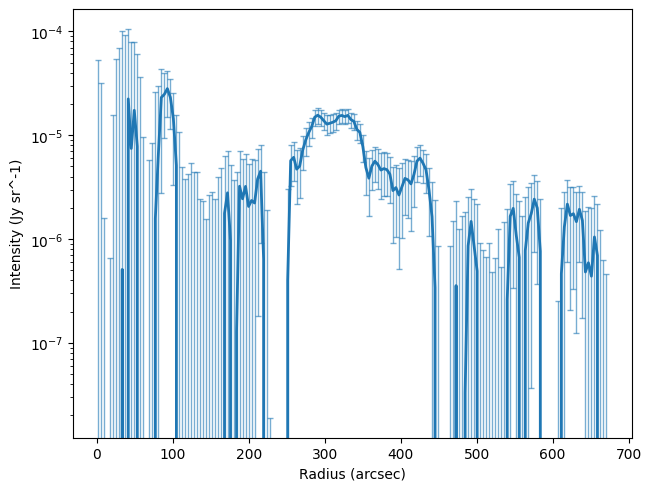

In [6]:
# A simple example plot of the nonaxisymmetric residuals for disk AA_Tau with robust value 0.5
# Adapting from section 4.2 of the exoALMA IV paper
# Keep the unit as Jy/beam at the moment, despite paper uses Jy/sr

cube = all_disks["AA_Tau"].get_cube("1.0", cube_type="residual")
#cube = imagecube('D:\exoALMA_disk_data\AA_Tau\images_frank_residuals_different_robust\AA_Tau_continuum_resid_robust0.5.image.fits', FOV=10.0)

x, y, dy = cube.radial_profile(inc=all_disks["AA_Tau"].inc, PA=all_disks["AA_Tau"].PA, unit='Jy/beam', dist=all_disks["AA_Tau"].distance_pc)  # return_au=False by default, so x is in arcsec
x=x * all_disks["AA_Tau"].distance_pc 
fig, ax = plt.subplots(constrained_layout=True)
# Plot the main line with a thicker width
ax.plot(x, y, color='C0', linewidth=2, label='Profile')
# Overlay lighter error bars
ax.errorbar(x, y, dy, fmt='none', ecolor='C0', alpha=0.6, elinewidth=1, capsize=2, label='Uncertainty')
ax.set_yscale('log')
ax.set_xlabel('Radius (arcsec)')  # nope, please be in au
ax.set_ylabel('Intensity (Jy sr^-1)')



# First , plot the full disk profile -> change the axes labels and calculations -> load the residuals 


And for the clean image to check if the result matches publication

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


Text(0, 0.5, 'Intensity (Jy beam^-1)')

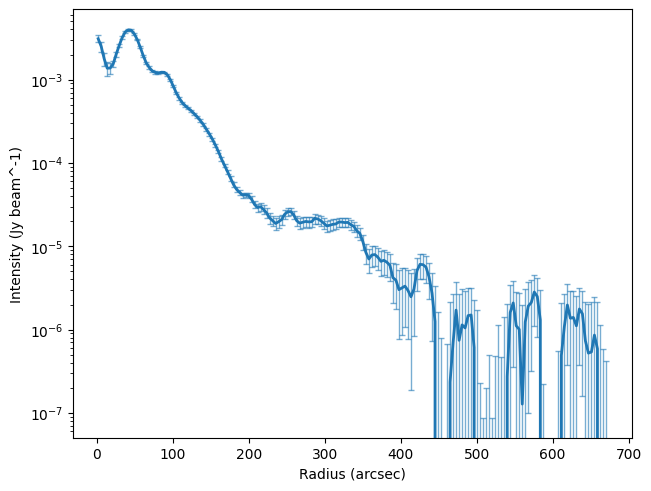

In [7]:
cube_cl = all_disks["AA_Tau"].get_cube("1.0", cube_type="clean")

x, y, dy = cube_cl.radial_profile(inc=all_disks["AA_Tau"].inc, PA=all_disks["AA_Tau"].PA, unit='Jy/beam')
x=x * all_disks["AA_Tau"].distance_pc 
fig, ax = plt.subplots(constrained_layout=True)
# Plot the main line with a thicker width
ax.plot(x, y, color='C0', linewidth=2, label='Profile')
# Overlay lighter error bars
ax.errorbar(x, y, dy, fmt='none', ecolor='C0', alpha=0.6, elinewidth=1, capsize=2, label='Uncertainty')
ax.set_yscale('log')
ax.set_xlabel('Radius (arcsec)')  # nope, please be in au
ax.set_ylabel('Intensity (Jy beam^-1)')




Checking that the plot_profile function in the DiskResidual class works.

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


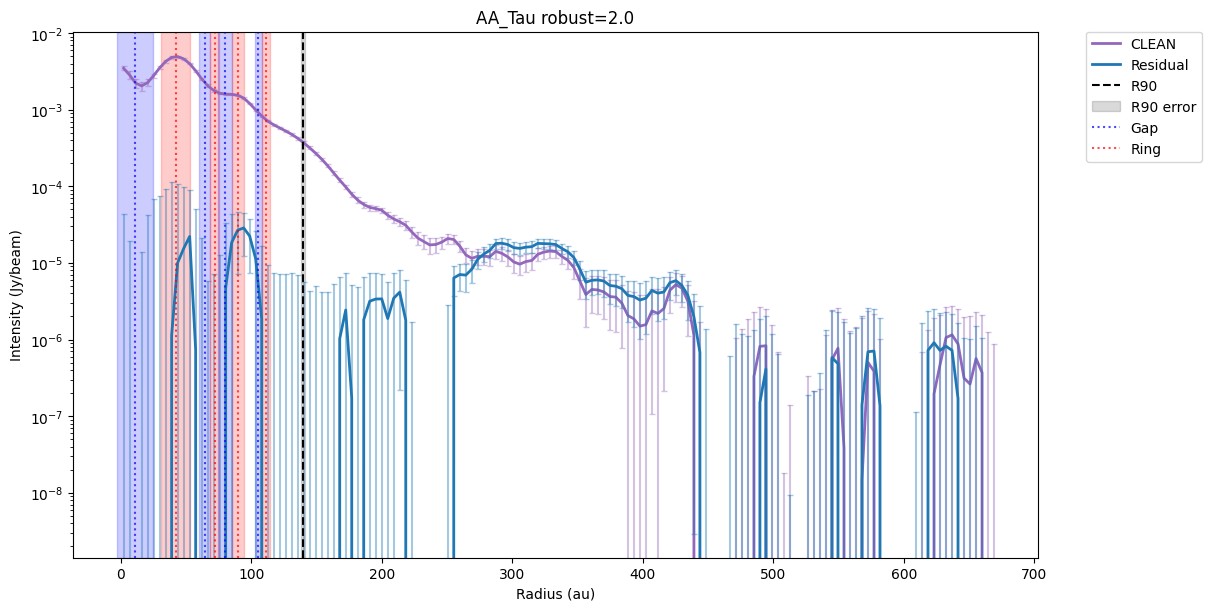

In [8]:
# unit transformation from Jy/beam to Jy/sr
# Jy/beam = Jy/sr * (beam area in sr)
# beam area extracted from the header of the FITS file

# --- IGNORE ---
# unit transformation from arcsec to au
# distance pc is NOT stored in the header of the FITS file


# Adapted from table 1 of the exoALMA X paper

all_disks["AA_Tau"].plot_profiles(robust_val="2.0", radius_unit="au")


Plotting: AA_Tau
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


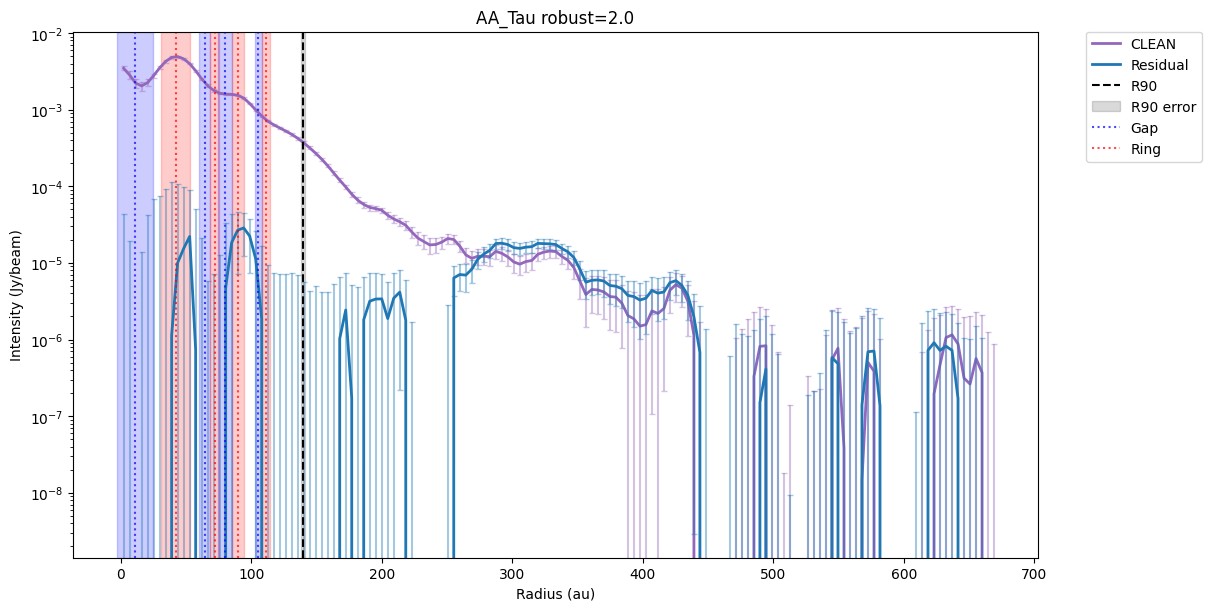

Plotting: CQ_Tau
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


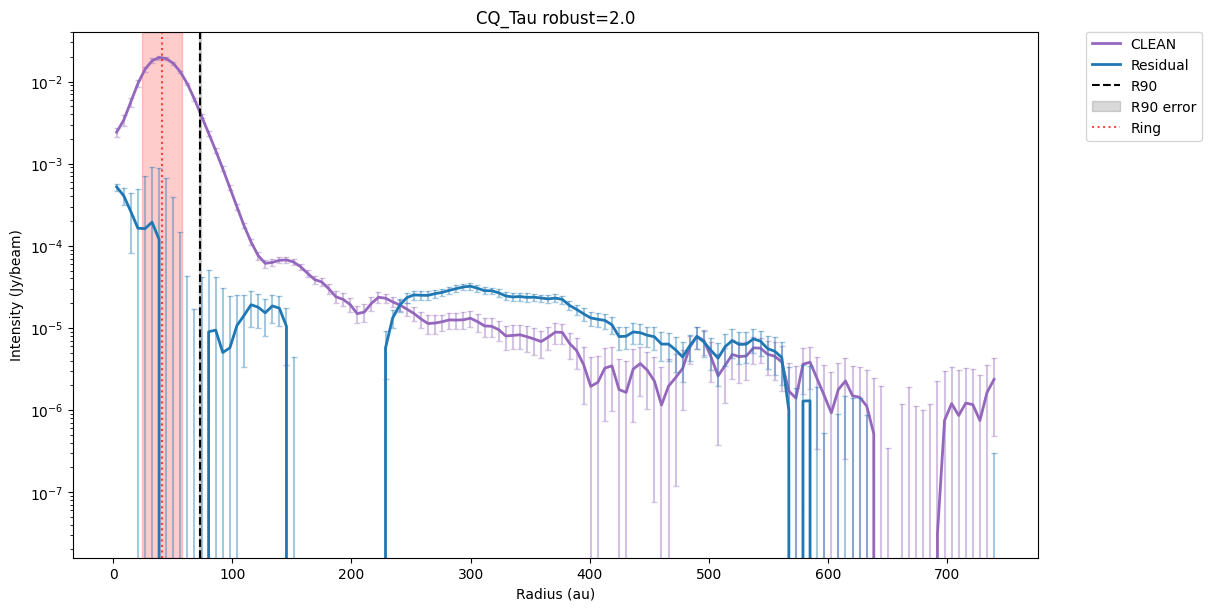

Plotting: DM_Tau
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


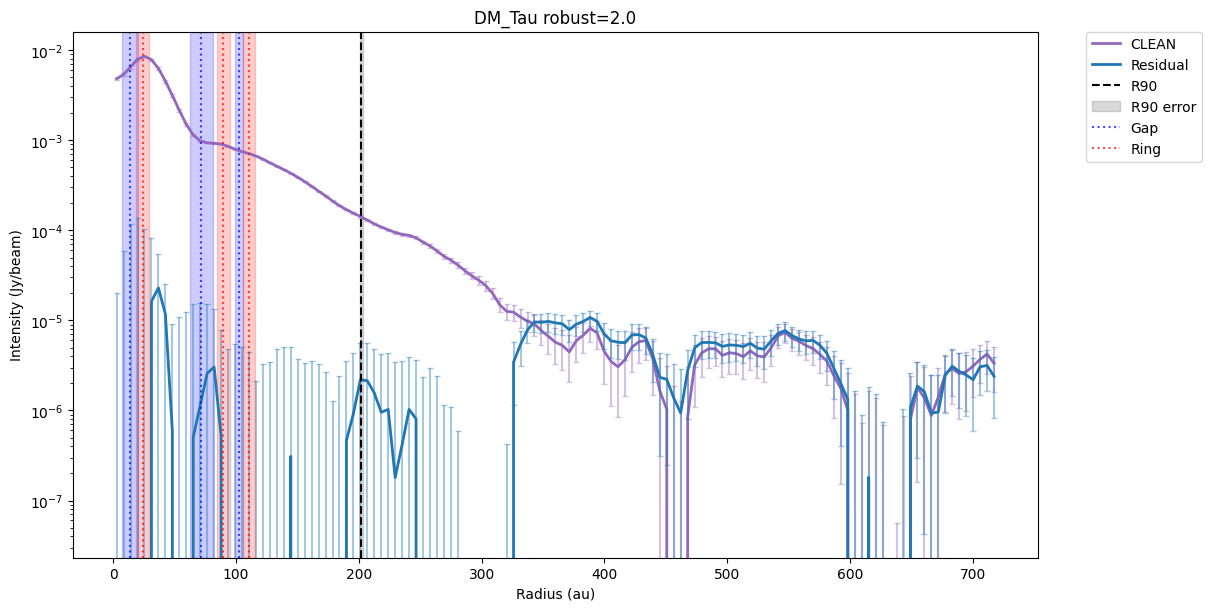

Plotting: HD_135344B
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


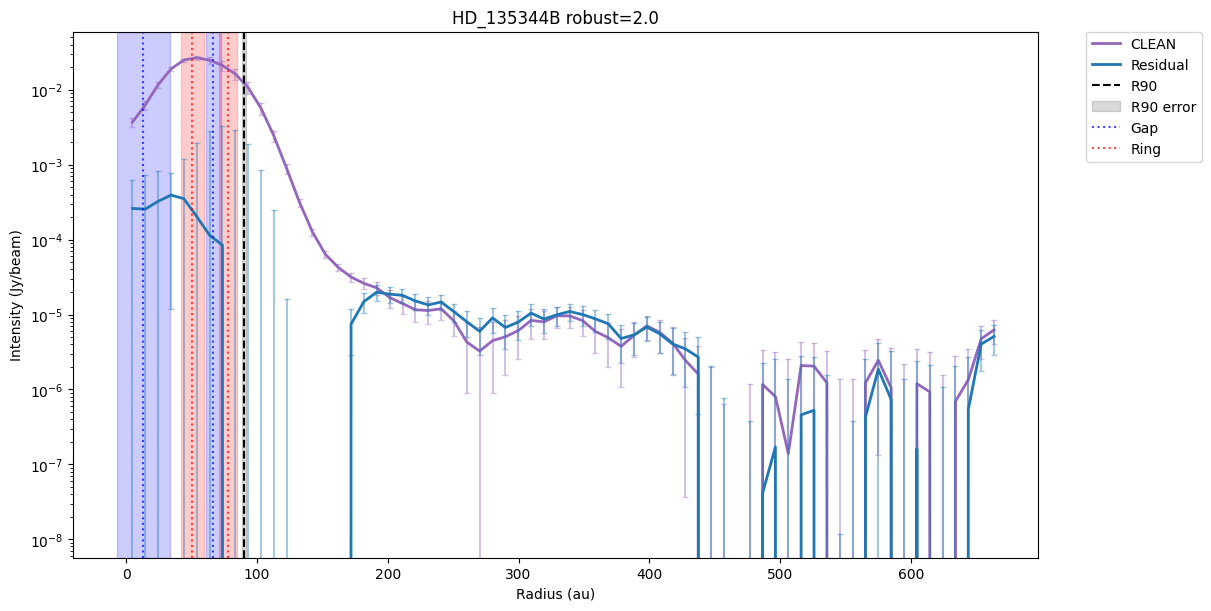

Plotting: HD_143006
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


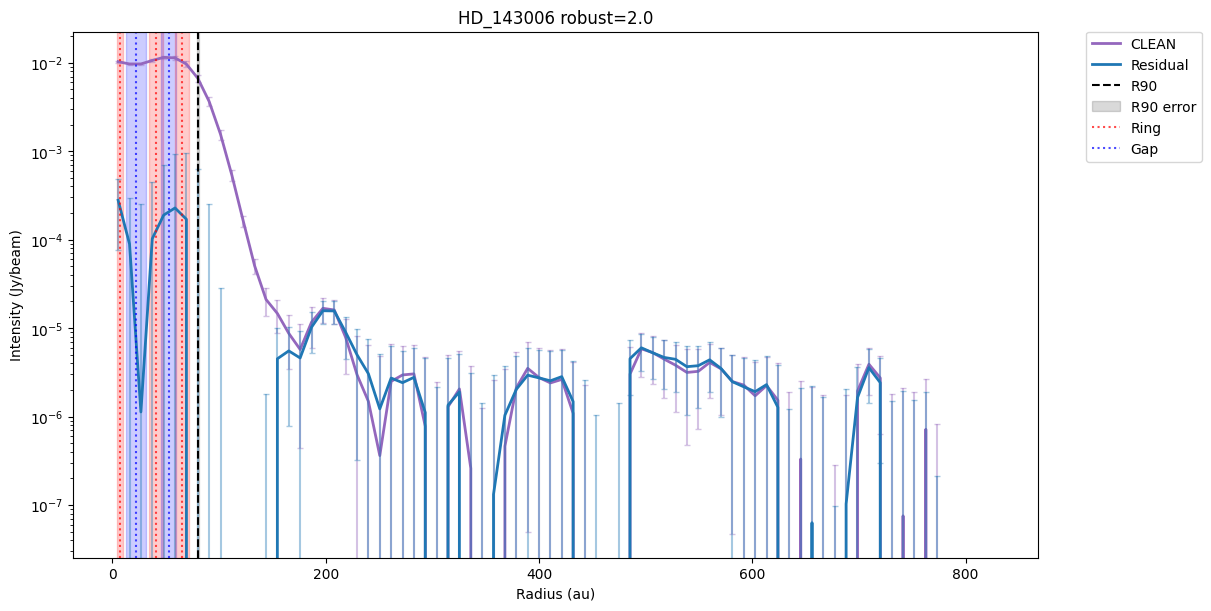

Plotting: HD_34282
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


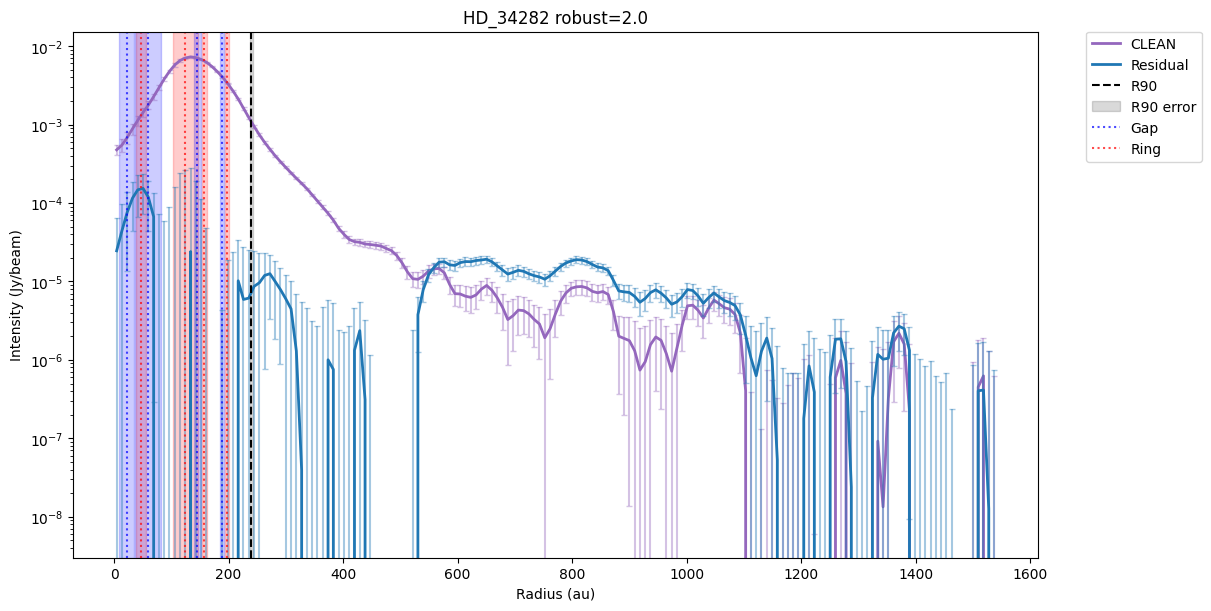

Plotting: J1604
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


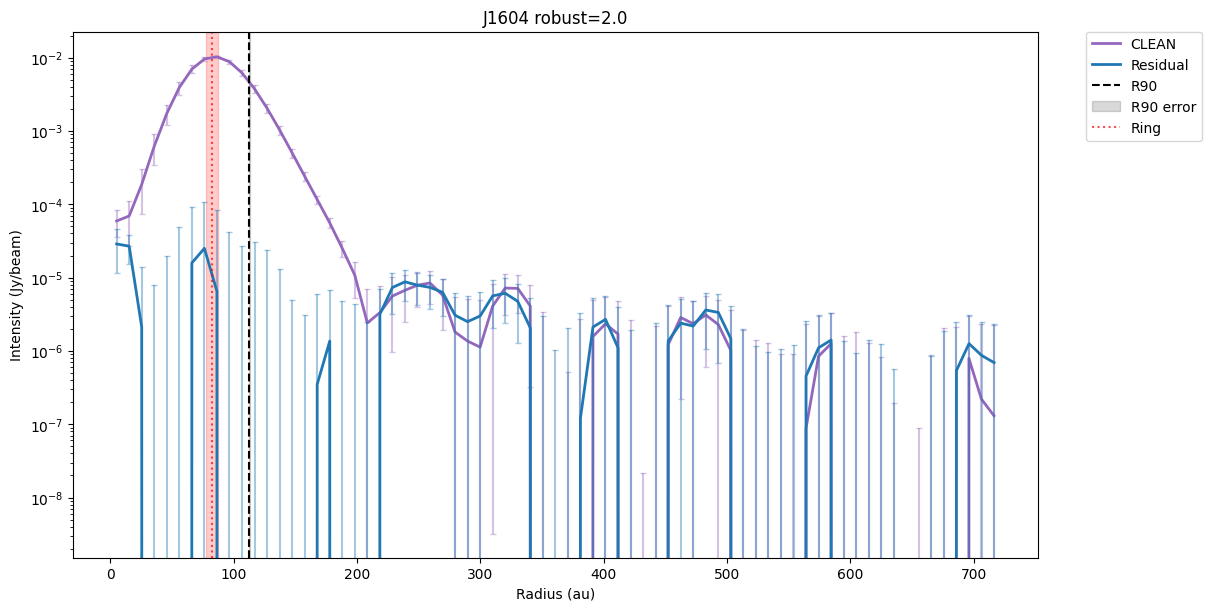

Plotting: J1615
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


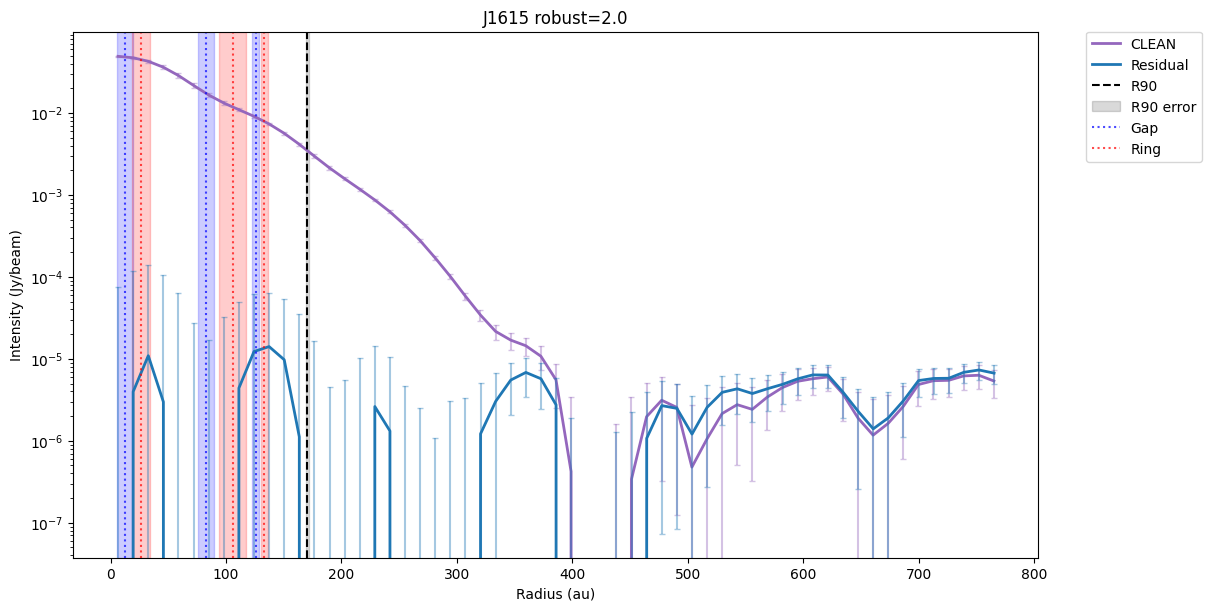

Plotting: J1842
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


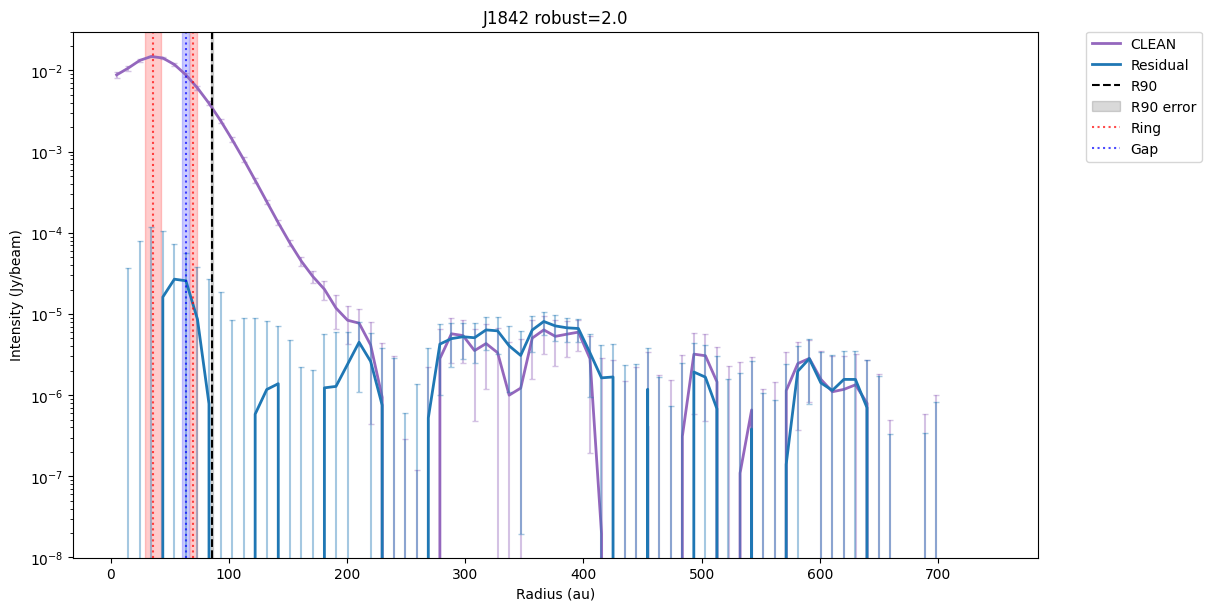

Plotting: J1852
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


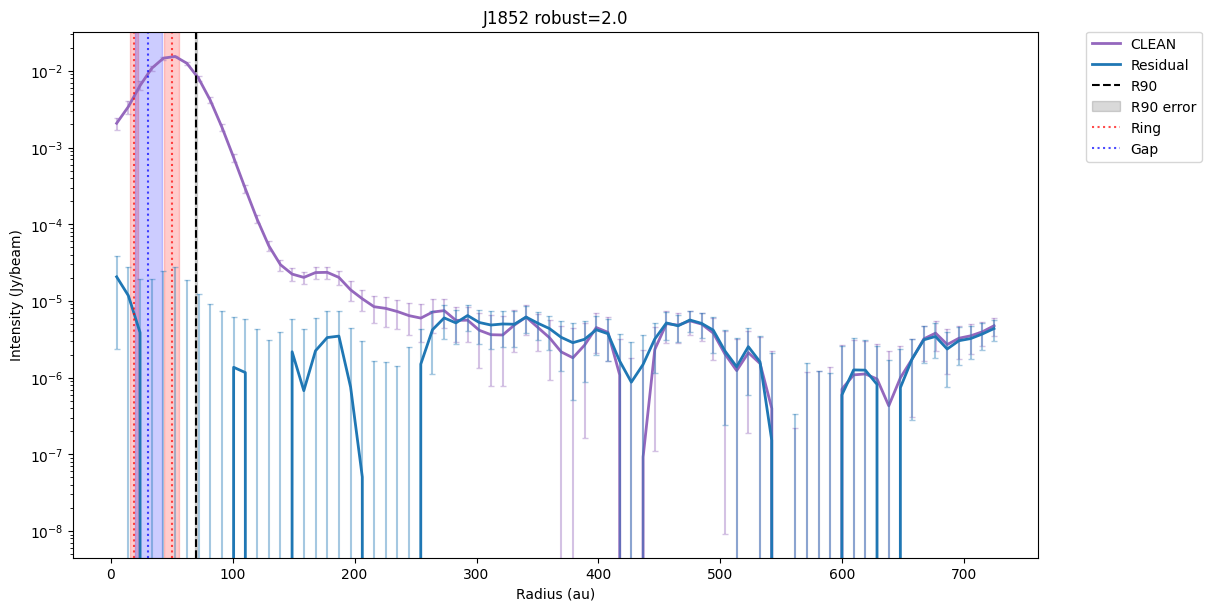

Plotting: LkCa_15
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


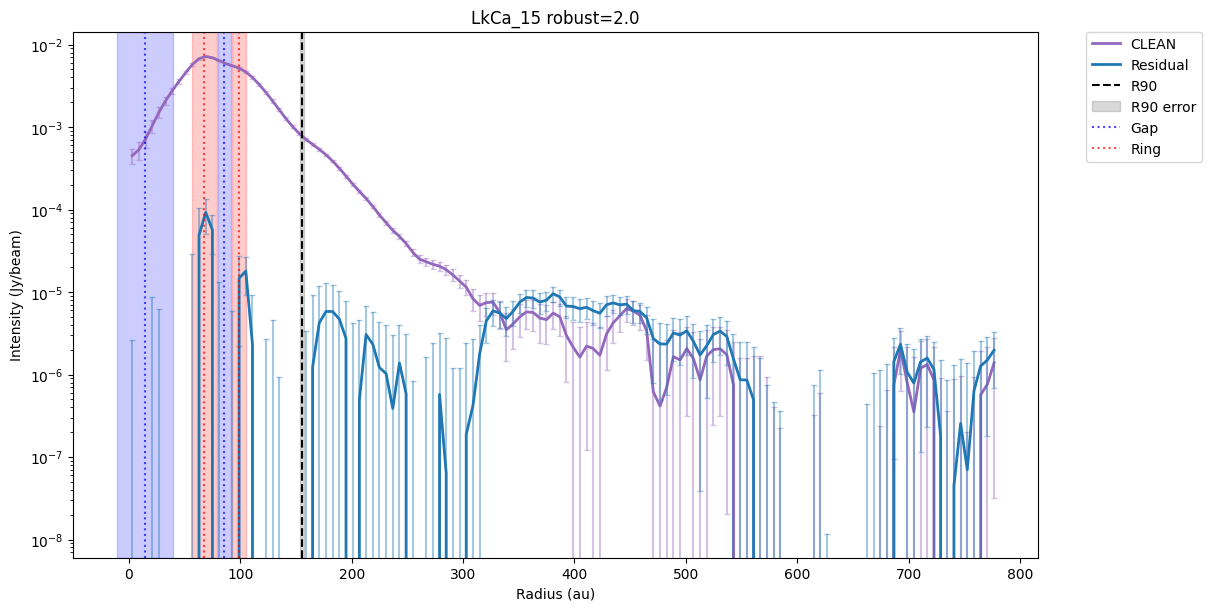

Plotting: MWC_758
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


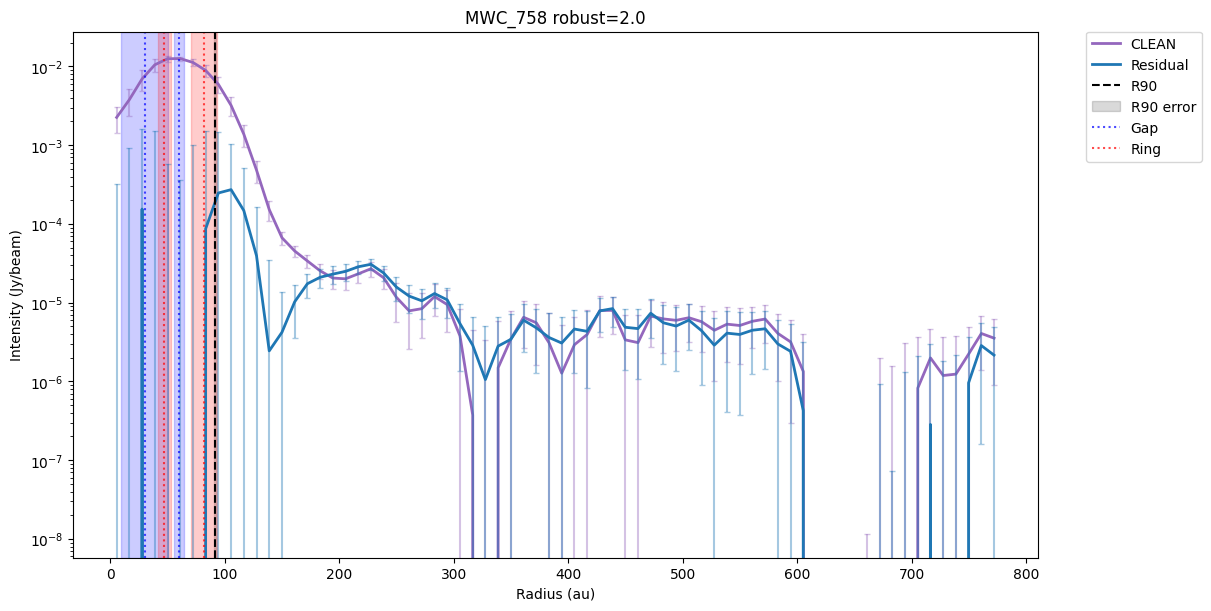

Plotting: PDS_66
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


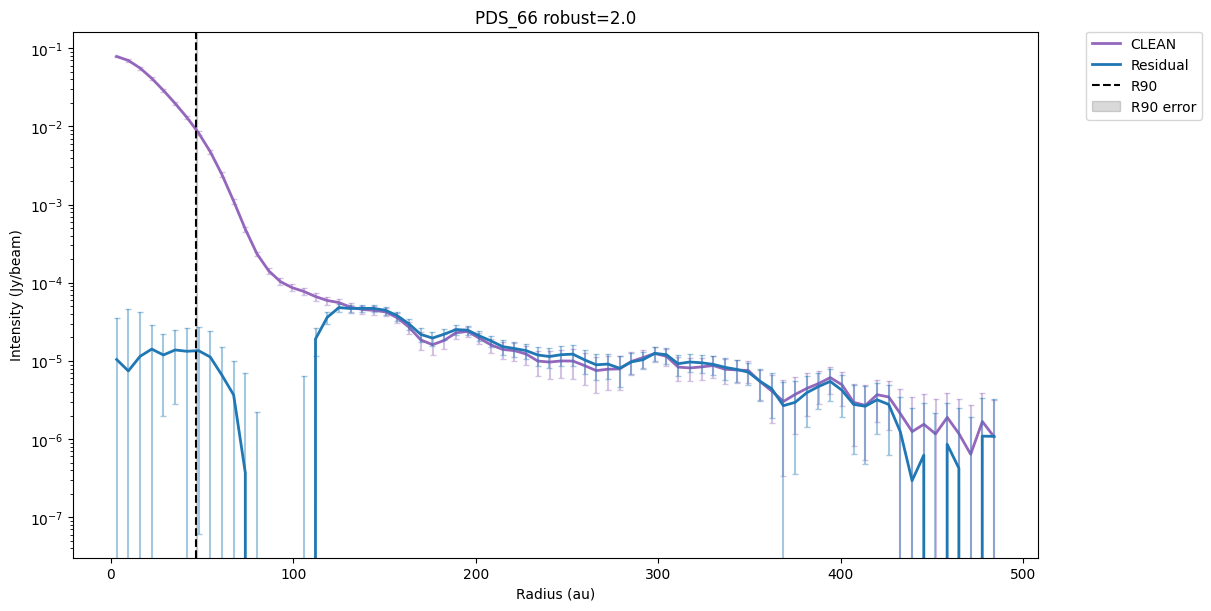

Plotting: SY_Cha
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


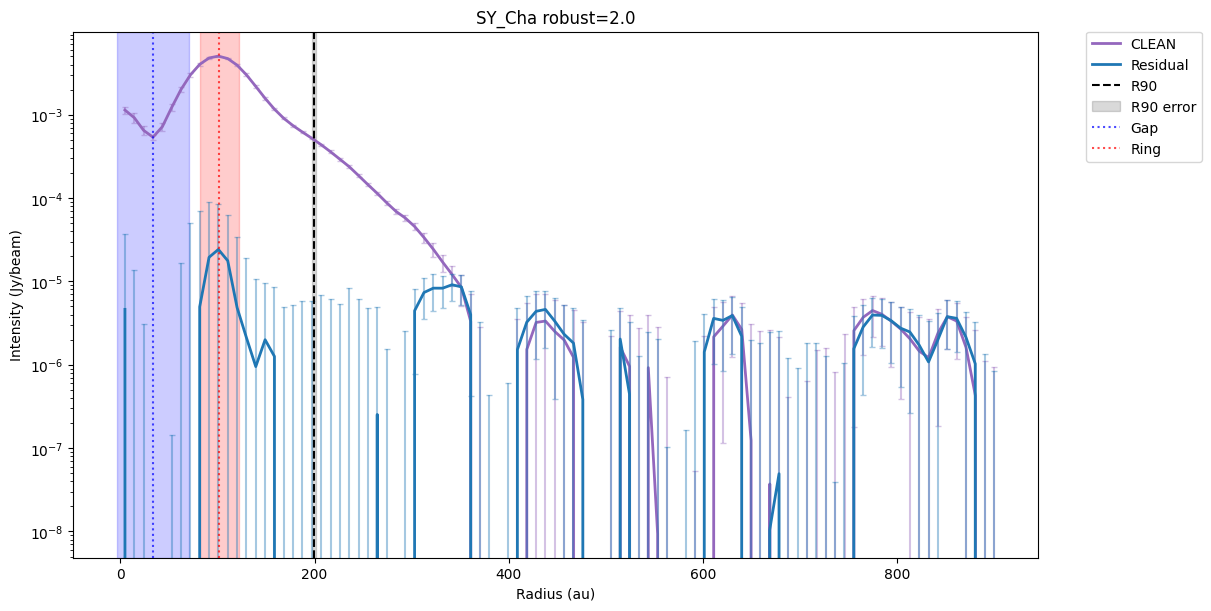

Plotting: V4046_Sgr
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


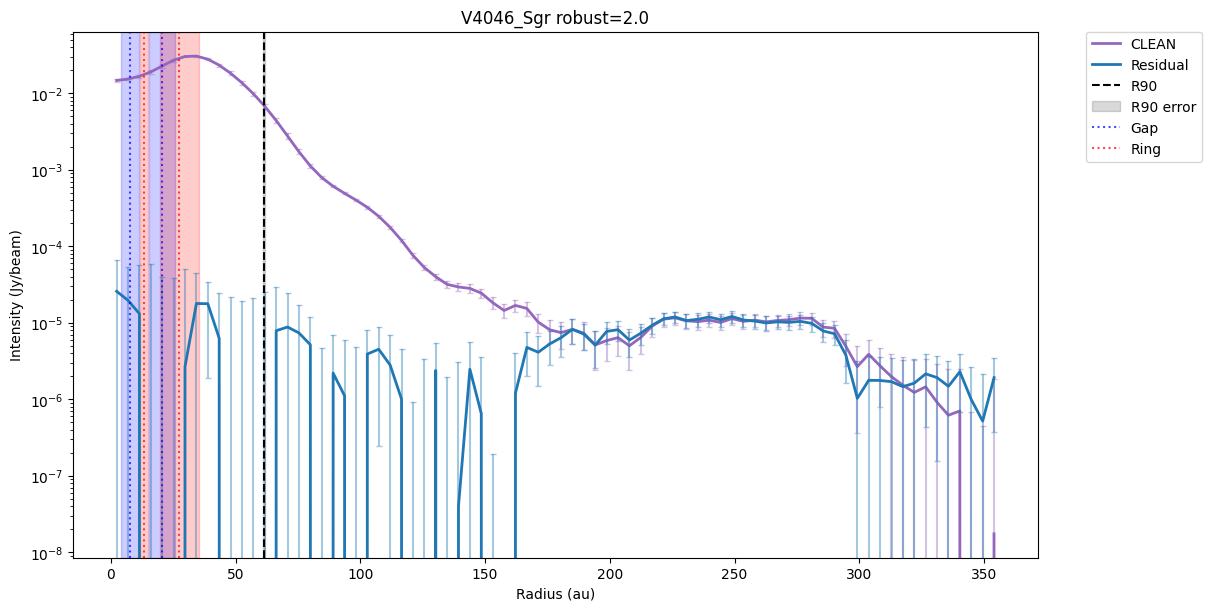

In [9]:
for disk_name, disk_obj in all_disks.items():
    print(f"Plotting: {disk_name}")
    disk_obj.plot_profiles(robust_val="2.0", radius_unit="au")

### Radial Profile Noise and Masking: Key Considerations

A challenge arises because the radial profile is azimuthally averaged. Even if we extract the standard deviation in each annulus, it's unclear how to:

1. Translate that 1D profile back to a 2D map that applies to the clean image.
2. Use it to mask pixels accordingly.

Also, it's important to distinguish between the **standard deviation** and **dy**:

- **Standard deviation**:  
  Measures the spread of beam intensity values within each annulus — i.e., the **noise per beam** in that region.

- **dy**:  
  By default of gofish, represents the *uncertainty on the mean intensity* in each annulus, and is typically calculated as:

  $$
  dy = \frac{\text{std}}{\sqrt{N_{\text{beams}}}}
  $$


  where $ N_{\text{beams}} $ is the number of independent beams in the annulus.




### Radial Uncertainty Estimation in `gofish.py`

The following code snippet shows how the number of **independent beams** is estimated in each annulus:

```python
        # Account for the number of independent beams.
        # Correlation： beams within annulus overlap -> fewer independent pixels -> 
        # only number of beams matter for uncertainty
        # If the beams are assumed to be correlated , then we
        # multiply the number of beams by 2*pi*r/bmaj, which is the
        # number of beams in the annulus.

        if assume_correlated:
            nbeams = 2.0 * np.pi * rvals / self.bmaj  #scales the uncertainty
        else:
            nbeams = 1.0

               # Averaging.

        if percentiles:  
            rstat = np.array([np.percentile(toavg[ridxs == r], [16, 50, 84])  
                              for r in range(1, rbins.size)]).T
            ravgs = rstat[1]
            rstds = np.array([rstat[1] - rstat[0], rstat[2] - rstat[1]])  # the diff betweern the 
                                                                          # 16th and 50th percentiles, 
                                                                          # and the 50th and 84th percentiles
                                                                          #  as lower and upper uncertainties
            rstds /= np.sqrt(nbeams)[None, :]  # divide by the square root of the number of independent beams
        else:
            ravgs = np.array([np.mean(toavg[ridxs == r])
                              for r in range(1, rbins.size)])
            rstds = np.array([np.std(toavg[ridxs == r])
                              for r in range(1, rbins.size)])   # standard deviation of the pixels in 
                                                                #each radial bin
            rstds /= np.sqrt(nbeams)
        
```

I can also try setting `percentiles=True` in `_radial_profile_2D()` to estimate the residual standard deviation using the 16th–84th percentile range, instead of the standard deviation. This might be more robust if the distribution within bins is non-Gaussian.


In [10]:
# Load the residual radial_profile_2D again , but assume_correlated=False to get the standard deviation
# Output x,y,dy into txt
# reproject it back to a 2D Fits


# Load the residual radial profile with assume_correlated=False to get the standard deviation per bin
cube = all_disks["AA_Tau"].get_cube("1.0", cube_type="residual")
x, y, dy = cube.radial_profile(inc=all_disks["AA_Tau"].inc, PA=all_disks["AA_Tau"].PA, unit='Jy/beam', assume_correlated=False)

# Output x, y, dy to a text file
np.savetxt("AA_Tau_residual_radial_profile.txt", np.column_stack([x, y, dy]), header="radius intensity uncertainty")

# Reproject the radial profile back to a 2D FITS image

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


# Plot Dust Mass Versus Dust Size Profile

*One-sentence summary for Figure 3 in SR12c paper*
The dust mass required to produce a given observed flux, as a function of disk outer radius, under assumed disk parameters (like temperature, opacity, and surface density slope).

**Interpretation of figure 3**
- For disks larger than approximately 1 astronomical unit (au), the dust mass becomes relatively independent of the outer radius, which signifies an optically thin dust emission. 

- Conversely, for disks smaller than about 1 au, the curves become vertical. This indicates that the disks are optically thick, and a smaller disk requires a significantly higher mass to produce the same observed flux. 

In [11]:
# Let 3*sigma be the flux limit for each annulus
# Assume a temperature , surface density, opacity to plot an example profile for one annulus
# project the dy_values back to a 2D image, scale it up by 3 sigma and use it as a mask
# Pinpoint the outliers in position and plot them